In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import yaml

In [3]:
# Load the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
adr_df = pd.read_parquet(config["paths"]["ADR_DATASET"])
adr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69474 entries, 0 to 69473
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   rxnorm_ingredient_id  69474 non-null  object
 1   meddra_id             69474 non-null  int64 
 2   meddra_name           69474 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [5]:
adr_df["rxnorm_ingredient_id"] = adr_df["rxnorm_ingredient_id"].astype(str).str.strip()
adr_df["meddra_id"] = adr_df["meddra_id"].astype(int)

In [6]:
# Build vocabularies
drug_ids = adr_df["rxnorm_ingredient_id"].unique()
adr_ids  = adr_df["meddra_id"].unique()

drug2i = {d:i for i,d in enumerate(drug_ids)}
adr2i  = {a:i for i,a in enumerate(adr_ids)}

In [7]:
# Rows=drugs, Cols=ADRs
rows = adr_df["rxnorm_ingredient_id"].map(drug2i).values
cols = adr_df["meddra_id"].map(adr2i).values
data = np.ones_like(rows, dtype=np.float32)

num_drugs = len(drug_ids)
num_adrs  = len(adr_ids)

X = csr_matrix((data, (rows, cols)), shape=(num_drugs, num_adrs), dtype=np.float32)

In [8]:
print("Drugs:", num_drugs, "ADRs:", num_adrs, "Sparsity:", 1.0 - X.count_nonzero()/(num_drugs*num_adrs))

Drugs: 1028 ADRs: 4817 Sparsity: 0.9859701656503514


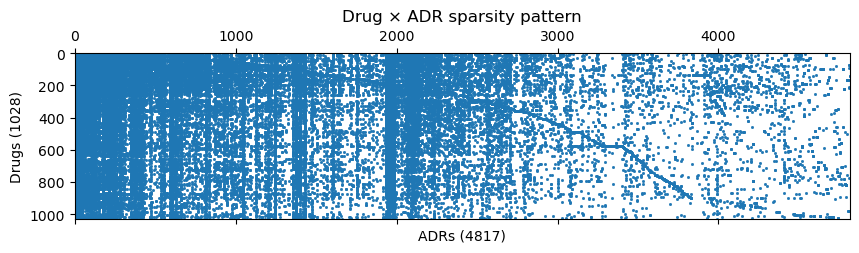

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.spy(X, markersize=1)
plt.title("Drug × ADR sparsity pattern")
plt.xlabel("ADRs (4817)")
plt.ylabel("Drugs (1028)")
plt.show()


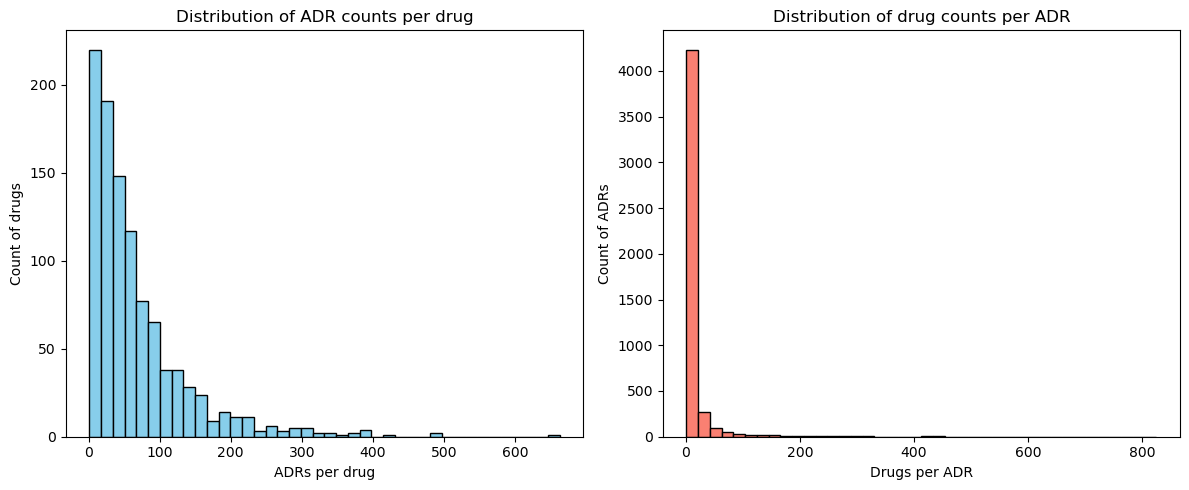

In [11]:
adrs_per_drug = np.asarray(X.sum(axis=1)).ravel()
drugs_per_adr = np.asarray(X.sum(axis=0)).ravel()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(adrs_per_drug, bins=40, color="skyblue", edgecolor="black")
plt.xlabel("ADRs per drug"); plt.ylabel("Count of drugs")
plt.title("Distribution of ADR counts per drug")

plt.subplot(1,2,2)
plt.hist(drugs_per_adr, bins=40, color="salmon", edgecolor="black")
plt.xlabel("Drugs per ADR"); plt.ylabel("Count of ADRs")
plt.title("Distribution of drug counts per ADR")

plt.tight_layout()
plt.show()


In [15]:
drug_idx = np.arange(num_drugs)
train_idx, val_idx = train_test_split(drug_idx, test_size=0.1, random_state=42, shuffle=True)



In [37]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import average_precision_score
from scipy.sparse import csr_matrix

In [42]:
num_drugs, num_adrs = X.shape
k = 256  # embedding size; try 32/64/128 later

# SVD + optional row L2 normalization (good for cosine similarity downstream)
svd = TruncatedSVD(
    n_components=k,
    n_iter=10,              # power iterations for stability
    random_state=42,
    algorithm="randomized", # default, fastest
)
pipeline = make_pipeline(svd, Normalizer(copy=False))  # Normalizer optional

# Fit on all drugs (unsupervised)
Z = pipeline.fit_transform(X)   # shape: (num_drugs, k)

print("Z shape:", Z.shape, "explained variance (sum):", svd.explained_variance_.sum())
print("explained variance ratio (sum):", svd.explained_variance_ratio_.sum())

Z shape: (1028, 256) explained variance (sum): 47.413483
explained variance ratio (sum): 0.8523822


In [43]:
import pickle, json
from pathlib import Path

EXPORT_DIR = Path("../Data/Encoder")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# You already have: `pipeline` (TruncatedSVD + Normalizer), `adr_ids`, `drug_ids`, `Z`
with open(EXPORT_DIR / "svd_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

meta = {
    "method": "TruncatedSVD+Normalizer",
    "k": 256,
    "num_drugs": int(Z.shape[0]),
    "num_adrs": int(len(adr_ids)),
    "adr_axis_dtype": "int",
    "drug_axis_dtype": "str",
    "explained_variance_ratio_sum": float(pipeline.named_steps['truncatedsvd'].explained_variance_ratio_.sum()),
}
(EXPORT_DIR / "meta.json").write_text(json.dumps(meta, indent=2))

# Freeze the ADR axis order so future transforms use the same column layout
(EXPORT_DIR / "adr_axis.json").write_text(json.dumps(list(map(int, adr_ids)), indent=2))


57806

In [44]:
Z_df = pd.DataFrame(Z, columns=[f"adr_svd_{i}" for i in range(Z.shape[1])])
Z_df.insert(0, "rxnorm_ingredient_id", list(map(str, drug_ids)))

# (optional) smaller file with float16
Z_f16 = Z_df.copy()
for c in Z_f16.columns[1:]:
    Z_f16[c] = Z_f16[c].astype("float16")

Z_df.to_parquet(EXPORT_DIR / "ADRFeatures.parquet", index=False)
Z_f16.to_parquet(EXPORT_DIR / "ADRFeaturesF16.parquet", index=False)

print("Saved:", EXPORT_DIR / "ADRFeatures.parquet", Z_df.shape)

Saved: ..\Data\Encoder\ADRFeatures.parquet (1028, 257)
